In [1]:
import sys
sys.path.insert(0, '..')

from AttentionModule import Conv2d_Attn

import torch
from torch import nn
from torchvision import models, datasets, transforms
import torch.optim as optim
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms

import re
import numpy as np

from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [2]:
resnet_attn = torch.load('58_val_attn.pkl')

In [3]:
resnet_attn = resnet_attn.eval().cuda()

In [4]:
batch_size = 32
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
transform = transforms.Compose(
    [transforms.ToTensor(),
     normalize])

trainset = torchvision.datasets.ImageFolder(root='../data/train', transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

In [5]:
blks = list(resnet_attn.children())

In [10]:
batch, _ = next(iter(trainloader))

In [11]:
pre_pool_outs = []
out = Variable(batch).cuda()
for i, layer in enumerate(blks):
    if isinstance(layer, torch.nn.modules.linear.Linear):
        out = out.view(out.size(0), -1)
    out = layer(out)
    if i == 8:
        pre_pool_outs.append(out.squeeze().data.cpu().numpy())
        break

In [14]:
post_pool = np.vstack(pre_pool_outs)

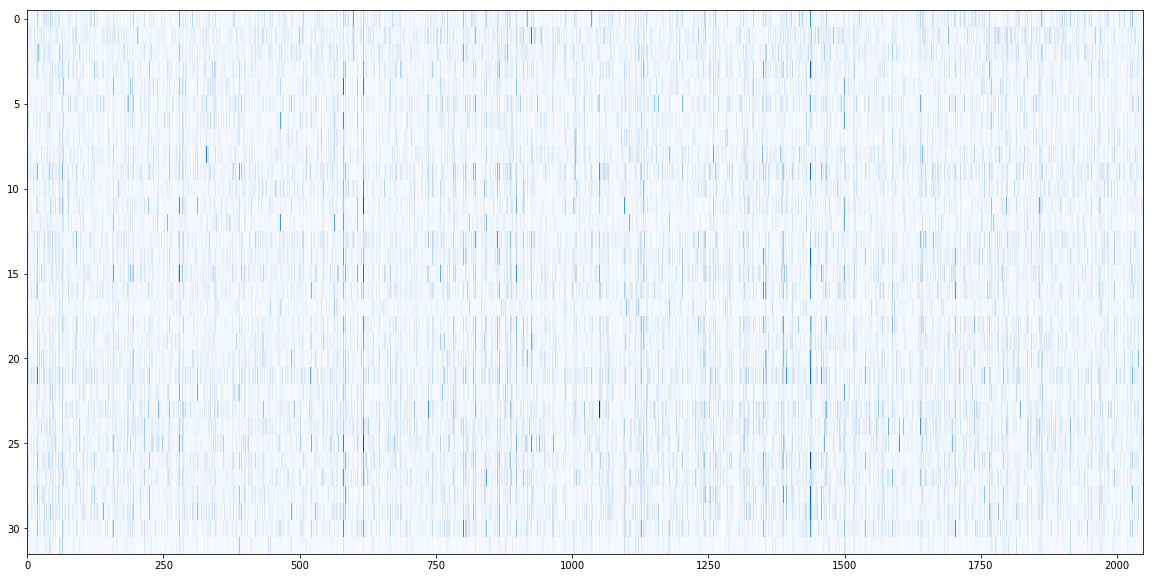

In [15]:
plt.figure(figsize=(20,10))
plt.imshow(post_pool,cmap='Blues',aspect='auto')

In [16]:
resnet50 = models.resnet50(pretrained=True)

In [17]:
resnet50 = resnet50.eval().cuda()

In [18]:
res50_pre_pool_outs = []
out = Variable(batch).cuda()
for i, layer in enumerate(list(resnet50.children())):
    if isinstance(layer, torch.nn.modules.linear.Linear):
        out = out.view(out.size(0), -1)
    out = layer(out)
    if i == 8:
        res50_pre_pool_outs.append(out.squeeze().data.cpu().numpy())
        break

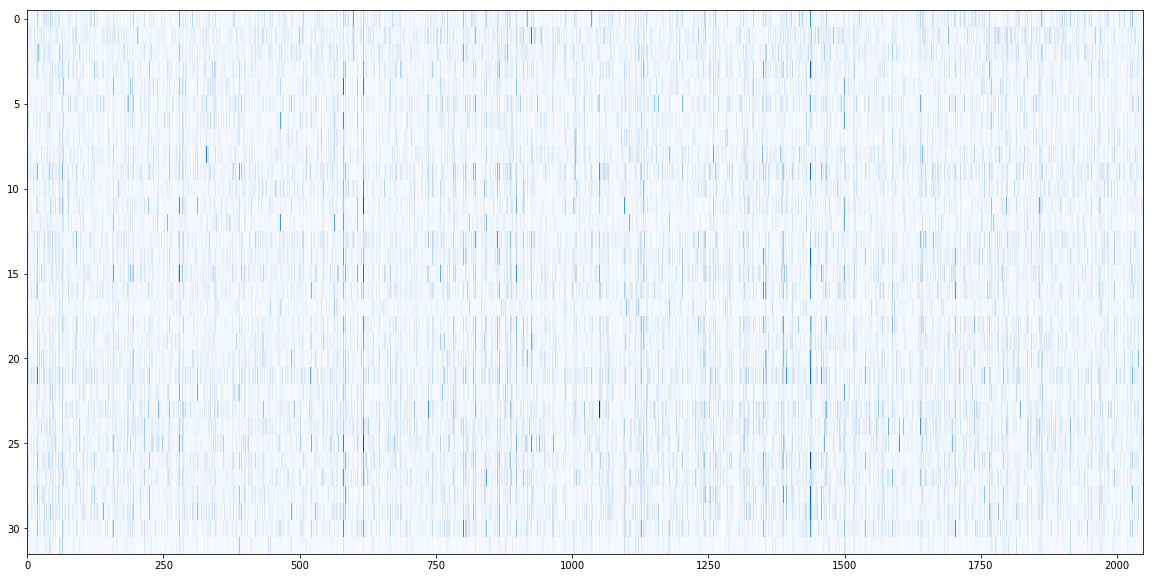

In [20]:
plt.figure(figsize=(20,10))
plt.imshow(post_pool,cmap='Blues',aspect='auto')

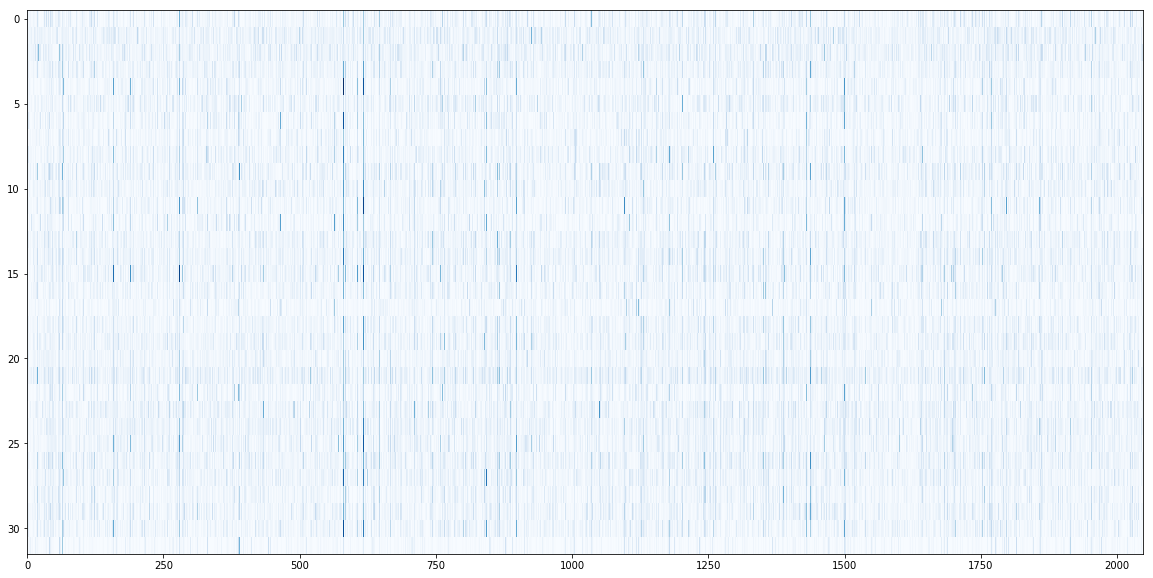

In [19]:
plt.figure(figsize=(20,10))
plt.imshow(np.vstack(res50_pre_pool_outs),cmap='Blues',aspect='auto')

In [21]:
res50_pre_pool_outs = np.vstack(res50_pre_pool_outs)

In [22]:
res50_pre_pool_outs.shape

(32, 2048)

In [27]:
res50_centroid = res50_pre_pool_outs.mean(axis=0).reshape(1,-1)

In [28]:
res50_centroid.shape

(1, 2048)

In [34]:
res50_l2_dist = ((res50_pre_pool_outs - res50_centroid)**2).sum(axis=1)

In [35]:
sum(res50_l2_dist)

8626.40151977539

In [37]:
attn_centroid = post_pool.mean(axis=0).reshape(1,-1)
attn_l2_dist = ((post_pool - attn_centroid)**2).sum(axis=1)

In [38]:
sum(attn_l2_dist)

24977.317626953125